In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, dot, SimpleRNN, Attention
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2023-06-14 12:53:13.297931: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load and preprocess the data
df = pd.read_csv('../Datasets/AMD Historical Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Extract the 'Close' price column for prediction
data = df[['Price']]

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train = data[:train_size]
test = data[train_size:train_size+test_size]
val = data[train_size+test_size:]

print(f"train shape: {train.shape}")
print(f"val shape: {val.shape}")
print(f"test shape: {test.shape}")

train shape: (1127, 1)
val shape: (162, 1)
test shape: (322, 1)


In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(train)
val_data = scaler.transform(val)
test_data = scaler.transform(test)

print(f"train_data shape: {train_data.shape}")
print(f"val_data shape: {val_data.shape}")
print(f"test_data shape: {test_data.shape}")

train_data shape: (1127, 1)
val_data shape: (162, 1)
test_data shape: (322, 1)


In [7]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((1026, 100, 1), (1026,), (221, 100, 1), (221,), (61, 100, 1), (61,))

In [10]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [11]:
def this_is_a_spectacular_model(input_shape, units):
  input_layer = tf.keras.Input(shape=input_shape)
  lstm_output = SimpleRNN(units)(input_layer)
  attention = Attention()([lstm_output, lstm_output])
  output = Dense(1)(attention)
  model = Model(inputs=input_layer, outputs=output)
  return model

In [12]:
# 8. Define RNN Model

model = this_is_a_spectacular_model(input_shape=(time_step,1), units=50)
# model.summary()

# Neu nhu phat hien overfitting,sau 3 epoch, val_loss ko co cai thien se dung train
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')

model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mean_absolute_error'])

In [13]:
# 9. Fit mô hình với dữ liệu train
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=64,verbose=1, callbacks=[callback])

Epoch 1/100
17/17 [==============================] - 1s 20ms/step - loss: 0.0885 - mean_absolute_error: 0.2168 - val_loss: 0.1356 - val_mean_absolute_error: 0.3568
Epoch 2/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0400 - mean_absolute_error: 0.1795 - val_loss: 0.0586 - val_mean_absolute_error: 0.2243
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0127 - mean_absolute_error: 0.0890 - val_loss: 0.0262 - val_mean_absolute_error: 0.1353
Epoch 4/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0063 - mean_absolute_error: 0.0618 - val_loss: 0.0161 - val_mean_absolute_error: 0.1016
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_absolute_error: 0.0563 - val_loss: 0.0127 - val_mean_absolute_error: 0.0884
Epoch 6/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_absolute_error: 0.0515 - val_loss: 0.0105 - val_mean_absolute_error: 0.0791
Epoch 7/100
17/17 

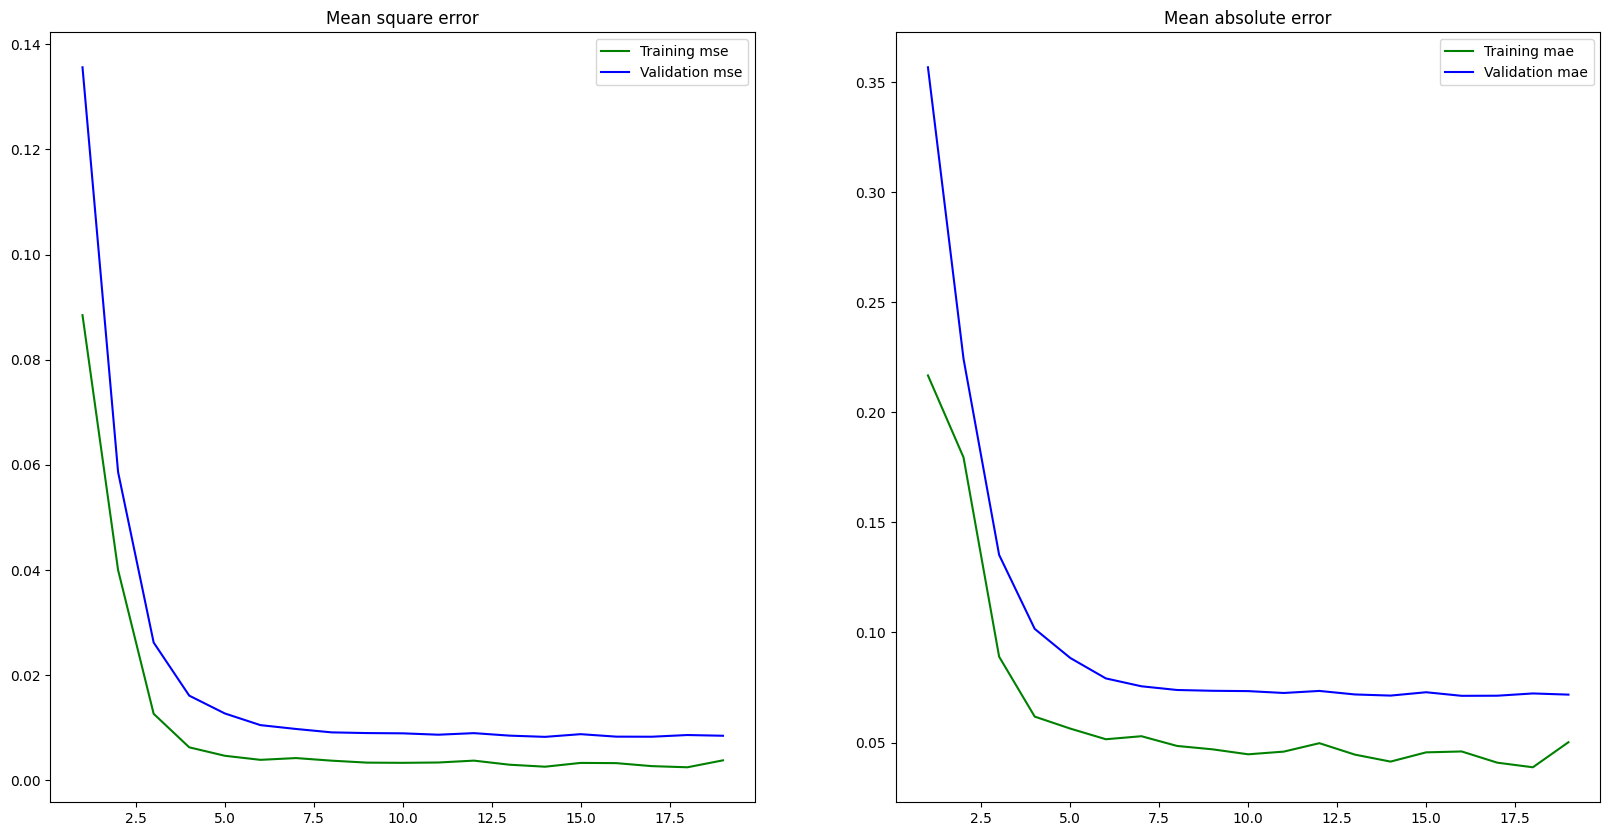

In [14]:
mae_train = history.history['mean_absolute_error']
mae_val = history.history['val_mean_absolute_error']

mse_train = history.history['loss']
mse_val = history.history['val_loss']

epochs = range(1, len(mae_train) + 1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(epochs, mse_train, 'g', label='Training mse')
plt.plot(epochs, mse_val, 'b', label='Validation mse')
plt.title('Mean square error')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, mae_train, 'g', label='Training mae')
plt.plot(epochs, mae_val, 'b', label='Validation mae')
plt.title('Mean absolute error')
plt.legend()

plt.show()

In [15]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

2/2 [==============================] - 0s 4ms/step
Validation RMSE: 90.85135481676596
Testing RMSE: 98.18469160920792


In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[61:].reshape(1,-1)
print(f"x_input shape: {x_input.shape}")

temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(f"temp_input shape: {len(temp_input)}")

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


x_input shape: (1, 101)
temp_input shape: 101
0 day input [0.62847697 0.60191518 0.62049704 0.65788874 0.66712266 0.67863657
 0.69847241 0.70075239 0.70747834 0.69539444 0.66324669 0.69015048
 0.76379389 0.74293206 0.74532604 0.74817601 0.75091199 0.71728226
 0.74806202 0.85624715 0.89808482 0.87277702 0.84530324 0.87072503
 0.85681715 0.83994528 0.82022344 0.83903329 0.87118103 0.8624031
 0.80426357 0.78625171 0.76652987 0.76470588 0.8005016  0.78157775
 0.78932969 0.7871637  0.78385773 0.80836753 0.82067943 0.81657547
 0.82740538 0.86456908 0.84929321 0.83378933 0.82626539 0.88828089
 0.91370269 0.99259006 1.00672595 0.99498404 0.98495212 1.00376197
 1.03454172 1.00797994 0.99270406 0.96933425 0.98677611 1.00718194
 1.00866393 0.99213406 0.98426813 0.94653443 0.94550844 0.97982216
 0.96329229 0.94391245 0.94117647 0.9373005  0.91586867 0.91484268
 0.91666667 0.91860465 0.8994528  0.88964888 0.84667123 0.87106703
 0.88816689 0.91016872 0.91381669 0.91632467 0.82181943 0.87870497
 0.91

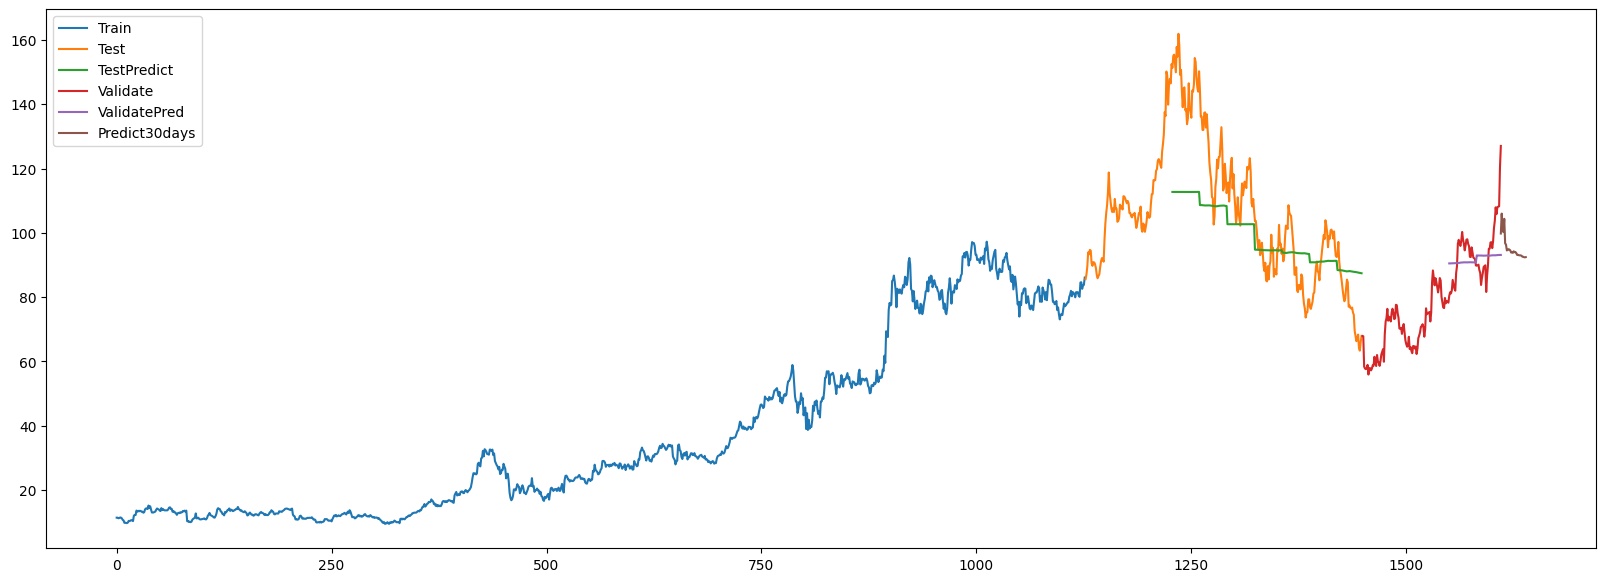

In [17]:
# 14.Vẽ hình
plt.figure(figsize=(20,7))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

predict_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+29, step=1)

plt.plot(predict_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','TestPredict','Validate','ValidatePred','Predict30days'])
plt.show()